In [1]:
from config import hdf5_path, spec_minmax_scaler_path, spec_log_transformer_path
from data_loader import SpectLoader
from model import ConvNetwork
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
import librosa
import torch.nn.functional as F
from torch.nn import ReLU
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
def data_dist(pprocessor, train_keys, threshold=0.05):
    num_bins = 50
    bin_edges = np.linspace(start=0.0, stop=1.0, num=num_bins + 1)  # Adjust the range based on your data's expected value range

    bin_counts = np.zeros(num_bins)
    for x_batch, _ in pprocessor.batch_generator(train_keys):
        
        data = x_batch.numpy() if hasattr(x_batch, 'numpy') else x_batch

        flattened_data = data.flatten()

        hist, _ = np.histogram(flattened_data, bins=bin_edges)
        bin_counts += hist  

    bin_counts_cumulative = np.cumsum(bin_counts)  

    bin_counts_cumulative = bin_counts_cumulative / bin_counts_cumulative[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(bin_edges[1:], bin_counts_cumulative, color='blue', alpha=0.7, lw=2)
    plt.title("Cumulative Distribution of Values in x_batch")
    plt.xlabel("Value")
    plt.ylabel("Cumulative Frequency")
    plt.grid(True)
    plt.show()

    bin_index_percentile = np.argmax(bin_counts_cumulative >= threshold)
    bin_start = bin_edges[bin_index_percentile]
    bin_end = bin_edges[bin_index_percentile + 1]

    print(f"The bin containing 5% of the data is between {bin_start} and {bin_end}")

    return bin_edges

def data_actual_dist(pprocessor, train_keys, num_bins=50):
    bin_edges = np.linspace(start=-1.0, stop=1.0, num=num_bins + 1)  # Adjust the range based on your data's expected value range

    bin_counts = np.zeros(num_bins)
    for x_batch, _ in pprocessor.batch_generator(train_keys):
        resized_tensor = F.interpolate(x_batch, size=(128, 512), mode='bilinear', align_corners=False, antialias=True)
        
        data = resized_tensor.numpy() if hasattr(resized_tensor, 'numpy') else resized_tensor

        flattened_data = data.flatten()

        hist, _ = np.histogram(flattened_data, bins=bin_edges)
        bin_counts += hist  

    # Normalize the bin counts to get probabilities (optional)
    bin_counts_normalized = bin_counts / bin_counts.sum()

    plt.figure(figsize=(10, 6))
    plt.bar(
        bin_edges[:-1], 
        bin_counts_normalized, 
        width=np.diff(bin_edges), 
        align="edge", 
        color="blue", 
        alpha=0.7
    )
    plt.title("Value Distribution in x_batch")
    plt.xlabel("Value")
    plt.ylabel("Frequency (Normalized)")
    plt.grid(True)
    plt.show()

    return bin_edges

def plot_spect(sepct):
    plt.figure(figsize=(10, 5))  # Adjust figure size as needed
    plt.imshow(sepct, aspect='auto', cmap='hot', origin='lower')
    plt.colorbar(label='Intensity')  # Optional: Add a colorbar
    plt.title('Spectrogram Heatmap')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

def plot_several(batch, n_show):
    for i in range(n_show):
        matrix = batch[i].squeeze(0).numpy()
        plot_spect(matrix)




In [3]:
paths = {
        "data_path": hdf5_path,
        "scaler_path": spec_minmax_scaler_path
    }

pprocessor = SpectLoader(paths, batch_size=32)
train_keys, val_keys, test_keys = pprocessor.split_data()
#pprocessor.fit_clipper()
pprocessor.setup_pipeline(scaler_type="normalizer",load_model=True)
#print(pprocessor.pipeline)

#_ = data_dist(pprocessor, train_keys)



{'feature_range': (-1, 1), 'min_': -100.0, 'scale_': 182.31103515625}
feature_range
min_
scale_


In [144]:
pprocessor.pipeline['scaler']

MinMaxScaler()

In [ ]:
sr = 44100  
n_mels = 64  
n_fft = 512 
id = 65
spectrogram = 10**(np.array(pprocessor.spect_data[pprocessor.train_keys[id]]['spectrogram'])/10)
mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
mel_spectrogram = np.dot(mel_filter_bank, spectrogram)
log_mel_spectrogram = 10 * np.log10(mel_spectrogram + 1e-17)
log_spectrogram = 10 * np.log10(spectrogram + 1e-17)

/var/folders/q_/nv9cmbv52rx2dhltp0q1l10h0000gn/T/ipykernel_98352/1280142163.py:6: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)


In [43]:
pprocessor.spect_data[pprocessor.train_keys[id]].attrs['genre']

'International'

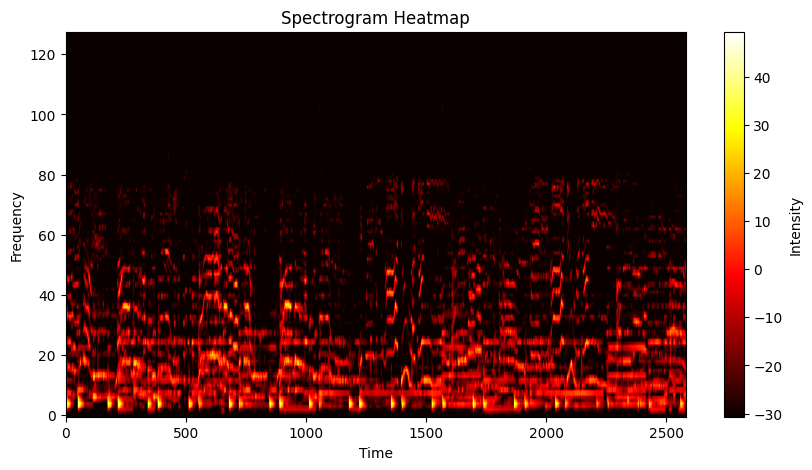

In [44]:
plot_spect(np.array(pprocessor.spect_data[pprocessor.train_keys[id]]['spectrogram']))

In [49]:
np.min(np.array(pprocessor.spect_data[pprocessor.train_keys[id]]['spectrogram']))

-30.654834830370127

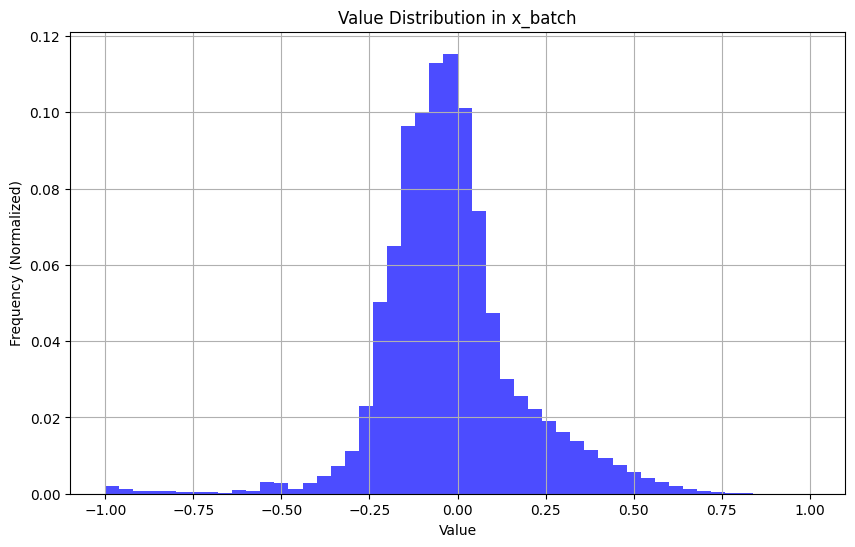

array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
       -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
       -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
        0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
        0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
        0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ])

In [6]:
data_actual_dist(pprocessor, train_keys, num_bins=50)

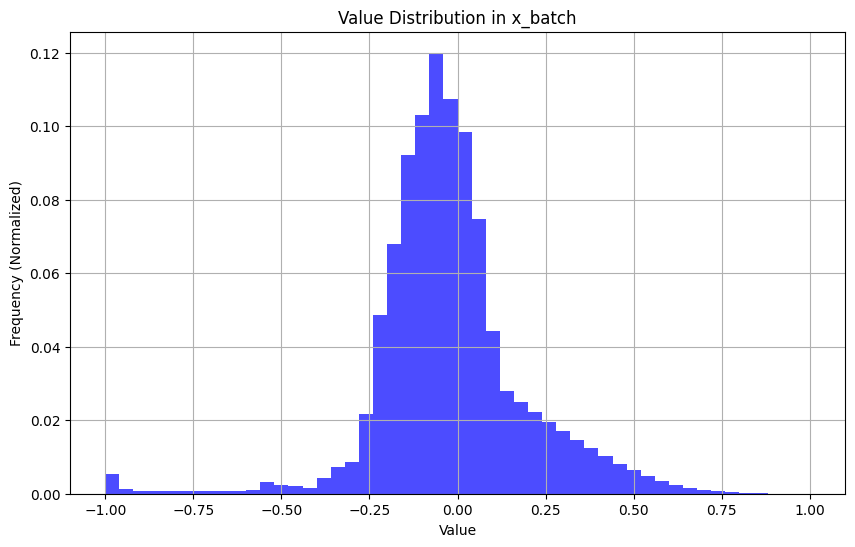

array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
       -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
       -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
        0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
        0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
        0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ])

In [6]:
data_actual_dist(pprocessor, train_keys, num_bins=50)

In [ ]:
model = ConvNetwork(input_shape=(1, 128, 512))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=3)

# get val set
x_val, y_val = next(pprocessor.batch_generator(val_keys, batch_size=-1))
x_val = F.interpolate(x_val, size=(128, 512), mode='bilinear', align_corners=False, antialias=True)

for i in range(50):
    train_accs = []
    train_losses = []
    for x_batch, y_batch in pprocessor.batch_generator(train_keys, batch_size=32):
        resized_tensor = F.interpolate(x_batch, size=(128, 512), mode='bilinear', align_corners=False, antialias=True)
        #plot_spect(resized_tensor[0].squeeze(0))

        optimizer.zero_grad()    

        outputs = model(resized_tensor)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_preds = torch.max(outputs, 1)
            train_accuracy = (train_preds == y_batch).float().mean().item()

        train_accs.append(train_accuracy)
        train_losses.append(loss.item())

        
    model.eval()
    with torch.no_grad():
        val_output = model(x_val)
        val_loss = criterion(val_output, y_val)

        _, val_preds = torch.max(val_output, 1)
        val_accuracy = (val_preds == y_val).float().mean().item()
        scheduler.step(val_loss.item())


    
    print(f'Avg. Training Loss: {np.mean(train_losses):.4f}, Avg. Train Accuracy: {np.mean(train_accs):.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f},')
    


    

weight (64, 4194304) | mean +0.000009 | std 2.994246e-04 | grad:data ratio 1.050152e+00
weight    (8, 64) | mean +0.000000 | std 1.574271e-01 | grad:data ratio 2.142348e+00


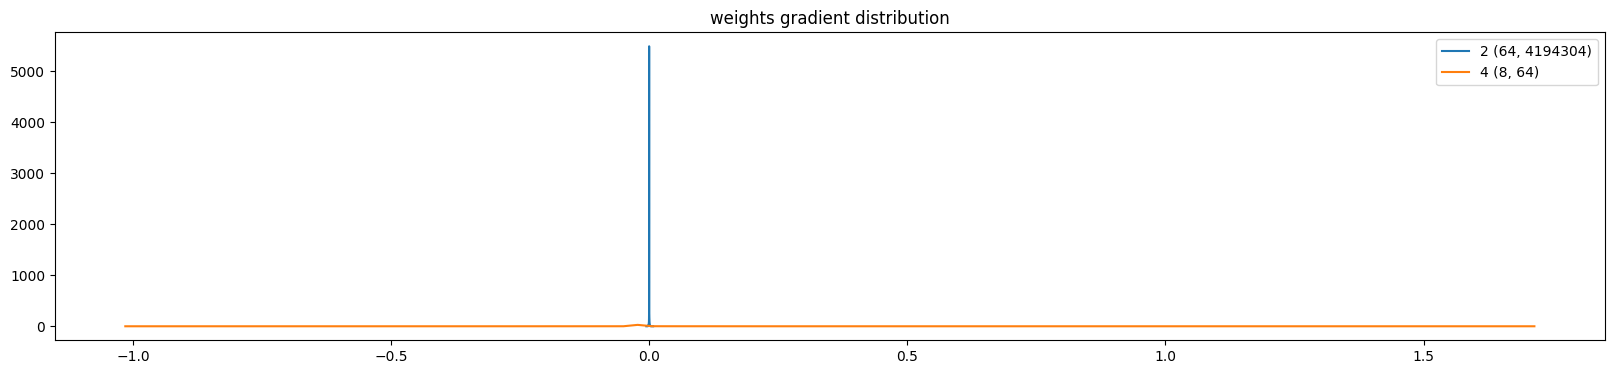

In [11]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(model.parameters()):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


mean +0.10, std 0.14, saturated: 50.32%
mean +1.63, std 4.28, saturated: 78.35%


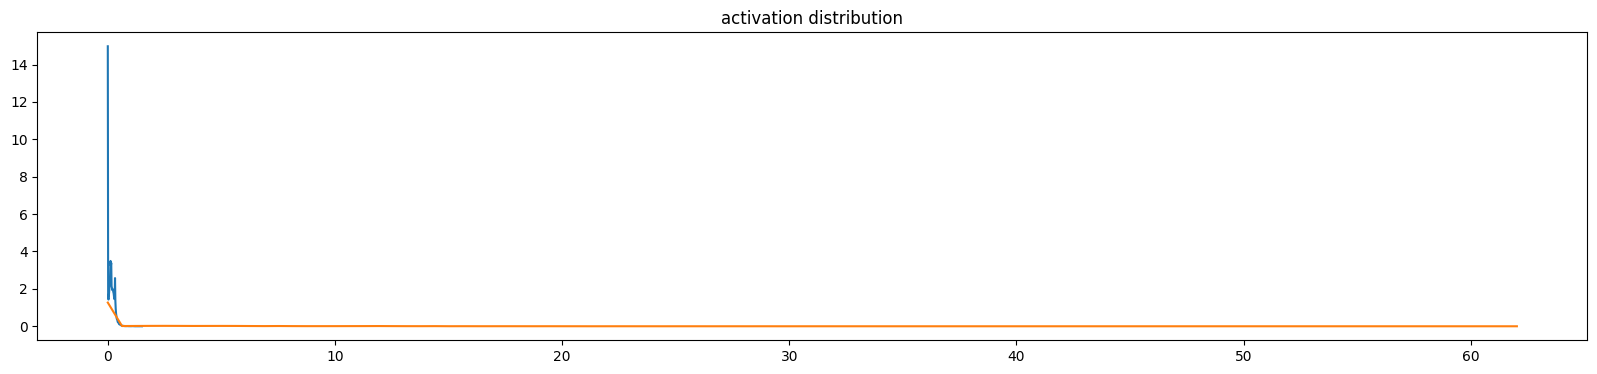

In [12]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for t in model.nonlin_acts:
  print('mean %+.2f, std %.2f, saturated: %.2f%%' % (t.mean(), t.std(), (t.abs() < 0.03).float().mean()*100))
  hy, hx = torch.histogram(t, density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  plt.title('activation distribution')